# Embedding

Sentence embeddings are vectors (lists of numbers) that represent the meaning of entire sentences.

Firstly we do prerocessing in [preprocessing.ipynb](../datasets/preprocessing.ipynb) <br>
Afterward we create the embedding using a sentence transformer

## Notebook Overview

1. Utils - used across the board. <br>
2. Sentence Transformers - explanation about why what and how of transformers. <br>
3. Refining Transformer - possilbe additions to make the sentence transformer the best. <br>

## Utils

### Imports

In [ ]:
%load_ext autoreload
%autoreload 2

from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

from datasets import load_dataset, Dataset

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import emoji
from urllib.parse import urlparse
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

import data.data_utils as data_utils
import model.model_utils as model_utils
import utils.gemini_client as gemini_client


def reload_utils():
    importlib.reload(gemini_client)
    importlib.reload(model_utils)
    importlib.reload(data_utils)


reload_utils()

In [ ]:
dataset_name = "jack_vs_calley_1000"
data = data_utils.get_comments(dataset_name)
tweets = data_utils.get_tweets()

In [ ]:
st_model = model_utils.get_sentence_transformer_model()
all_mpnet_base_v2 = SentenceTransformer('all-mpnet-base-v2')
all_MiniLM_L6_v2 = SentenceTransformer('all-MiniLM-L6-v2')

### Create Embeddings

In [ ]:
st_model = model_utils.get_sentence_transformer_model()
embeddings = st_model.encode(data)

### Hugging Face

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### Augment Tweets

#### Strategy

<u>**Default Denoising Stategy**</u> <br>
The default noising strategy in DenoisingAutoEncoderDataset (random token deletion with a 30% probability) is a good starting point, but it’s not optimized for tweets. <br>

<u>**Best Noising Strategy for Tweets**</u> <br>

**Conservative Token Deletion** - Delete tokens with a lower probability than the default (e.g., 10-15% instead of 30%) because tweets are short, and deleting too many tokens can destroy the meaning.
Avoid deleting critical tokens like hashtags, mentions, URLs, and emojis to preserve tweet-specific structure. <br>

**Token Swapping** - Swap adjacent tokens with a small probability (e.g., 10%) to simulate minor word order variations, which can happen in informal writing. Ensure swaps don’t break hashtags, mentions, or URLs.

**Token Replacement (Simulate Typos)** - Replace tokens with similar-looking characters (e.g., "the" → "teh") to mimic common typos in tweets. Use a small probability (e.g., 5-10%) to avoid overwhelming the text with typos.

#### Helpers

In [ ]:
def is_special_token(token):
    if token.startswith("#") or token.startswith("@"):
        return True
    elif contains_emoji(token):
        return True
    elif is_url(token):
        return True
    else:
        return False

def contains_emoji(token):
    for char in token:
        if char in emoji.EMOJI_DATA:
            return True
    return False

def is_url(token):
    try:
        result = urlparse(token)
        return all([result.scheme, result.netloc])
    except ValueError:
        return False

In [ ]:
def get_tokens_delete_conservative(tokens, deletion_prob = 0.1):
    noisy_tokens = []
    for token in tokens:
        if is_special_token(token) or random.random() > deletion_prob:
            noisy_tokens.append(token)

    return noisy_tokens

In [ ]:
def get_tokens_swapped(tokens, swap_prob = 0.1):
    noisy_tokens = tokens.copy()
    for i in range(len(noisy_tokens) - 1):
        if random.random() < swap_prob and not is_special_token(noisy_tokens[i]) and not is_special_token(noisy_tokens[i + 1]):
            noisy_tokens[i], noisy_tokens[i + 1] = noisy_tokens[i + 1], noisy_tokens[i]

    return noisy_tokens

In [ ]:
# Helper function to introduce a typo
def introduce_typo(word):
    if len(word) < 2:
        return word

    idx = random.randint(0, len(word) - 2)
    return word[:idx] + word[idx + 1] + word[idx] + word[idx + 2:]

def get_typo_tokens(tokens, typo_prob = 0.05):
    noisy_tokens = []
    for token in tokens:
        if is_special_token(token) or random.random() > typo_prob:
            noisy_tokens.append(token)
        else:
            noisy_tokens.append(introduce_typo(token))

    return noisy_tokens

#### Create Train Examples

In [ ]:
def add_noise(tweet, deletion_prob=0.1, swap_prob=0.1, typo_prob=0.05):
    tokens = tweet.split()
    tokens = get_tokens_delete_conservative(tokens, deletion_prob)
    tokens = get_tokens_swapped(tokens, swap_prob)
    tokens = get_typo_tokens(tokens, typo_prob)

    return " ".join(tokens)

# Test the noise function
tweet = "I love my new iPhone 📱 #TechLover @Apple https://apple.com"
noisy_tweet = add_noise(tweet)
print(f"Original: {tweet}")
print(f"Noisy: {noisy_tweet}")

Original: I love my new iPhone 📱 #TechLover @Apple https://apple.com
Noisy: I my iPhone new 📱 #TechLover @Apple https://apple.com


In [ ]:
train_examples = []
for tweet in tweets:
    augmented_tweet = add_noise(tweet)
    train_examples.append({"sentence1": tweet, "sentence2": augmented_tweet})

## Sentence Transformers

### Why ?

**Why are Transformers Used for This Task?** <br>
<u>Contextual Understanding</u>
Transformers excel at understanding the context of words within a sentence. They use an "attention mechanism" that allows them to weigh the importance of different words in the sentence when determining its meaning. They can effectively capture long-range dependencies between words in a sentence. This means they can understand how words that are far apart in a sentence relate to each other, which is essential for understanding the overall meaning of the sentence. <br>

<u>Pre-training and Fine-tuning</u>
Transformer models can be pre-trained on massive amounts of text data, allowing them to learn a deep understanding of language. This pre-trained knowledge can then be fine-tuned for specific tasks, such as generating sentence embeddings.  <br>

<u>Superior Performance</u>
Transformer-based models have consistently achieved state-of-the-art results on a wide range of NLP tasks, including sentence embedding. Their ability to capture complex semantic relationships makes them ideal for this task.   

### What ?

#### Transformer Basics

##### Transformer Architecture

Transformer is a deep learning architecture 

* **Key Features:**
    * Attention Mechanism: This is the core of the Transformer, allowing the model to focus on relevant parts of the input.
    * Encoder-Decoder Structure: The original Transformer architecture consists of an encoder (to process the input) and a decoder (to generate the output).
    * Parallel Processing: Unlike recurrent neural networks (RNNs), Transformers can process input sequences in parallel, leading to faster training.

<img src="images/transformer-architecture.png">

##### Input Embedding

First we give every word a vector based on pre trained "Embedding Space". <br>
Existing models like GloVe: Global Vectors For Word Representation <br>
<img src="images/embedding-space.png" width="200" height="200">

##### Positional Encoder

Vector that gives contex based on position of word in sentence. <br>
The positional encodings have the same dimension d<sub>model</sub>
as the embeddings, so that the two can be summed. <br>
where pos is the position and i is the dimension. <br>
<img src="images/positional-encoder.png" width="300" height="200">

##### Multi Head Attention

How relevant is the i'th word to the other words. <br>
For every word we have an attention vector generated which captures contextual relationships between words. <br>
<img src="images/attention-vectors.png" width="400" height="200"> <br>

Each Word Vector is broken to into 3 same dimentional vectors. <Br>
Q - query: what im looking for. <br>
K - key: what i can offer. <br>
V - value: what i actaully have to offer. <br>

How are Q,K,V calculated ? <br>
For each of the h attention heads the models stores three weight matrices. <br>
W<sub>Q</sub><sup>(i)</sup>: The weight matrix for the Query projection. <br>
W<sub>K</sub><sup>(i)</sup>: The weight matrix for the Key projection. <br>
W<sub>V</sub><sup>(i)</sup>: The weight matrix for the Value projection. <br>
Each of these matrices has dimensions (d<sub>model</sub>, d<sub>k</sub>), where:
d<sub>model</sub> is the dimension of the input embeddings (e.g., 768 for BERT base).
d<sub>k</sub> is the dimension of the key/query/value vectors for each head (and is typically d<sub>model</sub>/h).
Total number of weights: So, for each head, you have d<sub>model</sub> * d<sub>k</sub> weights in each of the three matrices. For h heads, the total number of weights is 3 * h * d<sub>model</sub> * d<sub>k</sub>. Since d<sub>k</sub> is often d<sub>model</sub>/h, this simplifies to 3 * d<sub>model</sub><sup>2</sup>.

##### Add And Norm

Takes the output matrix from attention, keeps feeding the calculated input embedding. <br>
This is done to ensure there is stronger information signal that flows through deep networks. Required because of vanishing gradients problem in back propagation (gradient becomes 0 after many backpropagation). <br>
To prevent, we induce stronger signals from the inputs in different parts of the network.

#### BERT (Bidirectional Encoder Representations from Transformers)

BERT is a specific Transformer-based model developed by Google.
* **Key Features:**
    * **Encoder-Only:** Uses only the Transformer's encoder.
    * **Bidirectional Training:** Trained to understand context from both directions.
    * **Pre-training and Fine-tuning:** Pre-trained on a massive dataset, then fine-tuned for specific tasks.


#### Sentence Transformers

While you can derive sentence embeddings from BERT (e.g., by averaging word embeddings), the resulting embeddings are often not optimal for tasks that require comparing the semantic similarity of sentences. <br>

Sentence Transformers are a framework or a methodology. They don't dictate a single architecture. Instead, they provide a way to train Transformer models to generate high-quality sentence embeddings.   
You can use various base Transformer architectures (like BERT, RoBERTa, MPNet, etc.) within the Sentence Transformers framework. <br>

Input Sentence --> Tokenization --> Transformer Encoder --> Pooling --> Sentence Embedding <br>

"all-mpnet-base-v2" <br>
When you see a model like "all-mpnet-base-v2", that means that the MPNet base Transformer architecture was used, and then it was fine tuned using the sentence transformer methodology.   
Therefore, it is a sentence transformer, that uses the mpnet architecture

In [ ]:
st_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

##### Pooling

You can't directly compare the embedding of two sentences if they have different numbers of tokens.
You need a way to summarize the values of each sentence into a single, consistent representation.

The pooling layer produces a single set of numbers that represents the "summary" of the sentence.
This set of numbers is the sentence embedding.
Because the pooling layer always produces a fixed-size output, you can now easily compare the sentence embeddings of different sentences.

### How ?

#### Simalrity By Cosine

In [ ]:
text_index_to_compare = 13
similarity_scores = cosine_similarity(embeddings, embeddings)[text_index_to_compare]
similarity_df = pd.DataFrame({'similarity': similarity_scores, 'sentence': data})
similarity_df = similarity_df.sort_values('similarity', ascending=False)
display(similarity_df.head(20))

,similarity,sentence
13,1.000000,Wow is Calley tongue tied.
151,0.732786,Calley is bafflegabbing...
417,0.707256,Calley is stuttering a lot!
473,0.703315,Calley can’t stop yapping
641,0.683870,Whoa! Calley really took a shit on himself on ...
871,0.682947,Calley coming across pretty weak here
570,0.678009,Calley did himself no favors here
166,0.674701,It's hard not to see right through Calley's di...
688,0.671101,difficult to watch calley reminds me of a lawyer
586,0.670862,Calley is so pompus and creepy.


#### Embedding - Preprocessing

<img src="images/preprocessing.png">

Sentence Transformers handle preprocessing in a specific way that's optimized for creating effective sentence embeddings. <br>

**Tokenization:** <br>
typically use sub-word tokenization algorithms like WordPiece or Byte-Pair Encoding (BPE). These algorithms break words into smaller, more frequent units, which helps handle out-of-vocabulary words and reduces the vocabulary size. <br>

**Lowercasing (Optional):** <br>
Some Sentence Transformer models might apply lowercasing as a preprocessing step. However, this is not always the case. <br>

**No Stemming or Lemmatization:** <br>
Sentence Transformers generally do not perform stemming or lemmatization.
The reason is that these techniques can sometimes lose semantic information, which is crucial for generating accurate sentence embeddings.

**No Stop Word Removal:** <br>
Sentence Transformers also typically do not remove stop words.
The context provided by stop words can be important for understanding the meaning of a sentence. <br>

**Normalization:** <br>
Sentence Transformers do perform normalization in the sense that they convert the input text into a numerical representation (embeddings).
They also normalize the embeddings themselves, so that they have unit length. <br>

##### Tokenizaiton

splitting text into smaller units called tokens. These tokens can be words, subwords, or even characters.

**Special Tokens** <br>
[CLS] -> Added at the beginning of each input sequence and is used for classification tasks (`<s>`). <br>
[SEP] -> Separate two sentences in a sequence (`</s>`). <br>
[UNK] -> When a word is not found in the vocabulary, it's replaced with this. <br>
`##` - this token is together with the last token

**Padding** <br>
Transformers require input sequences to have a fixed length. <br>
The shorter sentences are padded with a special token, usually [PAD]. <br>
If some texts are longer than the length that the model can handl the texts are either truncated (cut off at the maximum length) or split into multiple segments.

**Remove Numbers:** <br>
Sentence Transformers might keep numbers as tokens, as they can sometimes carry semantic meaning.
If you want to remove them, you would need to do it as a separate preprocessing step before feeding the text to the Sentence Transformer.

**Remove Punctuation:** <br>
Sentence Transformers' tokenizers often handle punctuation marks as separate tokens.
They might keep some punctuation, as it can contribute to meaning (e.g., question marks, exclamation points).
If you want to remove all punctuation, you would have to do it beforehand.

**Remove Special Characters and Symbols:** <br>
Similar to punctuation, Sentence Transformers might keep some special characters and symbols.
Again, you would need to remove them manually if desired.

**Remove Non-English Words:** <br>
Sentence Transformers are typically trained on multilingual or English corpora.
They might not explicitly remove non-English words, but they might not produce meaningful embeddings for them.
If you want to filter out non-English words, you would need to do it beforehand.

**Remove Words with Less Than Three Letters:** <br>
Sentence Transformers generally do not filter out short words.
You would need to do this manually if you want to remove them.

In [ ]:
tokenizer = st_model.tokenizer
tokenized_texts = []
for text in data:
    tokens = tokenizer.tokenize(text)
    tokenized_texts.append(tokens)

# Print the tokenized texts
for tokens in tokenized_texts:
    print(tokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 384). Running this sequence through the model will result in indexing errors


['watch', 'this', 'episode', 'fully', 'un', '##cens', '##ored', '&', 'ad', '-', 'free', 'on', 'pat', '##re', '##on', ':', 'https', ':', '/', '/', 'pat', '##re', '##on', '.', 'com', '/', 'danny', '##jon', '##ess', '##up', '##port', 'the', 'show', 'by', 'checking', 'out', 'our', 'sponsors', ':', 'https', ':', '/', '/', 'bit', '.', 'l', '##y', '/', 'vii', '##adan', '##ny', '##jon', '##es', '-', 'try', 'vii', '##a', '&', 'use', 'code', 'danny', '##ht', '##tp', '##s', ':', '/', '/', 'white', '##ra', '##bb', '##ite', '##ner', '##gy', '.', 'com', '/', '?', 'ref', '=', 'dj', '##p', '-', 'use', 'code', 'dj', '##p', 'for', '20', '%', 'off']
['if', 'they', 'took', 'vaccines', 'off', 'the', 'market', '1', '/', '2', 'the', 'country', 'would', 'lose', 'their', 'shit', '.', 'these', 'two', 'lunatic', '##s', 'want', 'to', 'sacrifice', 'the', 'good', 'for', 'the', 'perfect', '.']
['call', '##ey', 'how', 'many', 'more', 'babies', 'and', 'parents', 'have', 'to', 'die', 'while', 'your', '##e', 'busy', 'wi

###### Tokenization Code Example

In [ ]:
tokens = tokenizer.tokenize("This is f* **ed and crazyyyy")
print(tokens)

['this', 'is', 'f', '*', '*', '*', 'ed', 'and', 'crazy', '##y', '##y', '##y']


In [ ]:
sentences = [
    "It was a great discussion",
    "Calley comes off shady AF.",
    "Total Jack count anyone?",
    "Wow is Calley tongue tied."
]
batch = tokenizer(sentences, padding=True)
print(batch)

{'input_ids': [[0, 2013, 2005, 1041, 2311, 6598, 2, 1, 1], [0, 2659, 3244, 3314, 2129, 22828, 21362, 1016, 2], [0, 2565, 2994, 4179, 3091, 1033, 2, 1, 1], [0, 10170, 2007, 2659, 3244, 4420, 5083, 1016, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
for ids in batch["input_ids"]:
    print(tokenizer.decode(ids))

<s> it was a great discussion </s> <pad> <pad>
<s> calley comes off shady af. </s>
<s> total jack count anyone? </s> <pad> <pad>
<s> wow is calley tongue tied. </s>


##### Lemmatization

determines the word base form, or lemma. It considers the context of the word and aims to produce actual words from the dictionary.   
Example:
Original words: "better," "good," "best"
Lemmatized words: "good," "good," "good"

Source: A systematic review of text stemming techniques.

##### Stop words

common words in a language that are often filtered out of text analysis tasks because they are considered to carry little semantic meaning or contribute minimally to the overall understanding of a text.

Examples of common English stop words include:
Articles: the, a, an
Prepositions: in, on, at, with, for
Conjunctions: and, or, but
Pronouns: I, you, he, she, it, they, we
Auxiliary Verbs: is, am, are, was, were, will, shall, can, could, may, might, must

**Why remove stop words?**
Reduced Dimensionality: By removing stop words, we can reduce the dimensionality of the text data, making it easier to process and analyze.
Improved Performance: Removing stop words can improve the performance of many NLP tasks, such as text classification, sentiment analysis, and information retrieval.
Focus on Key Words: By filtering out stop words, we can focus on the most important words in the text, which can lead to more accurate and meaningful analysis.

##### Stemming

reducing words to their root form by removing suffixes, prefixes, or other affixes. 
Example:
Original words: "cats," "catlike," "catty"   
Stemmed words: "cat", "catlik", "catti"   

Source: Kaur, J.; Buttar, P.K. A systematic review on stopword removal algorithms. Int. J. Future Revolut. Comput. Sci. Commun. Eng. 2018, 4, 207–210.

## Optimization

### Maximum Sequence Length

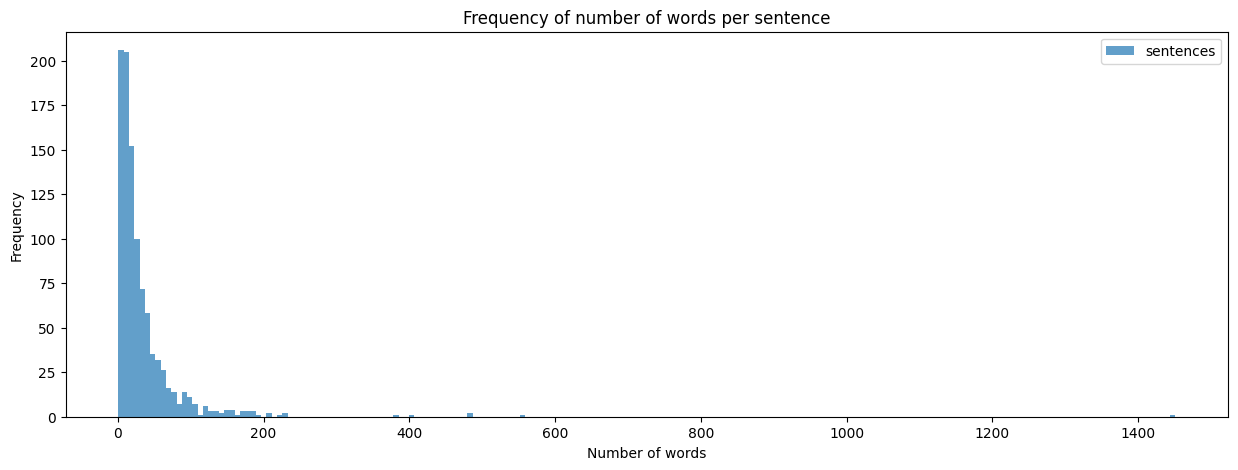

In [ ]:
word_counts = [len(sentence.split()) for sentence in data]

# Create the histogram
plt.figure(figsize=(15, 5))
plt.hist(word_counts, bins=200, alpha=0.7, label='sentences')

# Add title and labels
plt.title('Frequency of number of words per sentence')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
over_512 = sum(1 for count in word_counts if count > 512)
over_256 = sum(1 for count in word_counts if count > 256)

print(f"Number of sentences with over 512 words: {over_512}")
print(f"Number of sentences with over 256 words: {over_256}")

Number of sentences with over 512 words: 2
Number of sentences with over 256 words: 6


### Adding Vocabulary ?

In [ ]:
tokenizer = st_model.tokenizer
tokenized_texts = []
for text in data:
    tokens = tokenizer.tokenize(text)
    tokenized_texts.append(tokens)

# Print the tokenized texts
for tokens in tokenized_texts:
    print(tokens)

['watch', 'this', 'episode', 'fully', 'un', '##cens', '##ored', '&', 'ad', '-', 'free', 'on', 'pat', '##re', '##on', ':', 'https', ':', '/', '/', 'pat', '##re', '##on', '.', 'com', '/', 'danny', '##jon', '##ess', '##up', '##port', 'the', 'show', 'by', 'checking', 'out', 'our', 'sponsors', ':', 'https', ':', '/', '/', 'bit', '.', 'l', '##y', '/', 'vii', '##adan', '##ny', '##jon', '##es', '-', 'try', 'vii', '##a', '&', 'use', 'code', 'danny', '##ht', '##tp', '##s', ':', '/', '/', 'white', '##ra', '##bb', '##ite', '##ner', '##gy', '.', 'com', '/', '?', 'ref', '=', 'dj', '##p', '-', 'use', 'code', 'dj', '##p', 'for', '20', '%', 'off']
['if', 'they', 'took', 'vaccines', 'off', 'the', 'market', '1', '/', '2', 'the', 'country', 'would', 'lose', 'their', 'shit', '.', 'these', 'two', 'lunatic', '##s', 'want', 'to', 'sacrifice', 'the', 'good', 'for', 'the', 'perfect', '.']
['call', '##ey', 'how', 'many', 'more', 'babies', 'and', 'parents', 'have', 'to', 'die', 'while', 'your', '##e', 'busy', 'wi

as we can see some words are not in the vocabulary. utube (youtube), bitcoiner, doesnt understand the name kally, psychpath, behaving ..

In [ ]:
tokenzier = all_mpnet_base_v2.tokenizer
words = [
    "apple",
    "simp",
    "balloon",
    "delulu",
    "nepo baby",
    "rizz",
    "brainrot",
    "girl dinner",
]
vocabulary = tokenzier.get_vocab().keys()

for word in words:
    if word not in vocabulary:
        print(word)

simp
delulu
nepo baby
rizz
brainrot
girl dinner


### Training A Model ?

#### Comparing Training Methods


| **Method**                          | **How It Works**                                                                 | **Pros**                                                                 | **Cons**                                                                 |
|-------------------------------------|----------------------------------------------------------------------------------|--------------------------------------------------------------------------|--------------------------------------------------------------------------|
| **Standard Supervised Fine-Tuning** | Trains on labeled data with a task-specific loss (e.g., cosine similarity).     | High accuracy, task-specific optimization.                               | Requires labeled data, limited by dataset size/quality.                  |
| **Unsupervised Fine-Tuning**        | Uses unlabeled data with objectives like TSDAE (denoising) or SimCSE (contrastive). | No labeled data needed, adapts to domain.                                | Lower accuracy than supervised, depends on data quality.                 |
| **Self-Supervised (MLM)**           | Fine-tunes on unlabeled data by predicting masked words.                        | No labeled data needed, improves contextual understanding.               | Not task-specific, needs large data, requires further adaptation.        |
| **SetFit (Few-Shot Learning)**      | Trains on small labeled data with contrastive learning and an SVM classifier.   | Very efficient, needs little labeled data, fast training.                | Requires some labeled data, performance tied to dataset quality.         |
| **Zero-Shot Learning (LLM)**        | Uses an LLM to generate embeddings or classify via prompts, no fine-tuning.     | No training data needed, flexible, leverages LLM knowledge.              | Unpredictable performance, computationally expensive.                    |
| **Contrastive Learning (Hard Negatives)** | Trains with positive/negative pairs, often mining hard negatives (InfoNCE loss). | Improves fine-grained similarity, can be supervised or unsupervised.     | Requires careful pair selection, can be computationally intensive.       |
| **Knowledge Distillation**          | A teacher model (e.g., a larger bi-encoder) trains a smaller Sentence Transformer. | Transfers knowledge from a better model, efficient inference.            | Needs a trained teacher model, may lose some accuracy.                   |
| **Multi-Task Learning**             | Trains on multiple tasks (e.g., similarity, classification) simultaneously.     | Better generalization, leverages diverse data.                           | More complex to implement, requires diverse labeled data.                |

---

#### Contrastive Tension

Unsupervised method that uses two models. If the same sentences are passed to Model1 and Model2, then the respective sentence embeddings should get a large dot-score. If the different sentences are passed, then the sentence embeddings should get a low score

#### SimCSE (Simple Contrastive Learning of Sentence Embeddings)

##### SimCSE Explanation

SimCSE leverages contrastive learning. It takes a sentence and creates two slightly different versions of it, treating them as positive pairs.   
The core idea is to maximize the similarity between these positive pairs while minimizing the similarity between all other sentences (negative pairs) in the batch.   
The most common form of SimCSE uses dropout as the only form of data augmentation. Applying dropout twice to the same sentence yields two slightly different embedding

##### Shorter Training
  


Training initially looked like it was going to take 30 hours. so we took several steps in order to shorten it. <br>

If GPU:
* move model to cuda
* use amp (float 32 to 16)

CPU Meaasures: 
1. **Gradient Accumalation** - Instead of processing the entire batch at once, the batch is divided into smaller "micro-batches". The model performs a forward pass and a backward pass on each micro-batch.
The gradients are calculated for each micro-batch but are not immediately applied to update the model's weights. They are accumulated (added together). And After processing they are used to update the model's weights.

2. **Use Smaller Model** - MiniLM-L6-v2 instead of all-mpnet-base-v2

3. **Use Faster Optimizer** - AdamW instead of Adam

Other Considerations: num_workers not needed (data is small)

##### Training

In [ ]:
model = all_MiniLM_L6_v2
model_dir = os.path.join(model_utils.models_dir, "trained_miniLM_twitter")

In [ ]:
train_dataset = Dataset.from_list(train_examples)

train_loss = losses.MultipleNegativesRankingLoss(st_model)

# Define training arguments
training_args = SentenceTransformerTrainingArguments(
    output_dir=model_dir,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    warmup_steps=100,
    learning_rate=2e-5,
    weight_decay=0.01,
    optim="adamw_torch", 
    logging_steps=10,
    save_strategy="steps",
    save_steps=500,
    fp16=False,  # Disable mixed precision (not supported on CPU)
)

In [ ]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    loss=train_loss
)

In [ ]:
trainer.train()

Step,Training Loss
10,0.049600
20,0.031400


KeyboardInterrupt: 

#### TSDAE (Transformer-based Denoising Autoencoder)

**Problem - Most models are encoder only and do not support decoder**

If your data is significantly different from the general text that sentence transformer was trained on, TSDAE could help improve the model's performance. <br>

First, Corrupt a sentence in some way (e.g., randomly masking words, deleting words, or shuffling words). Than, we train the model to minimize the difference between the reconstructed sentence and the original sentence. <br>

<u>AutoEncoder</u> <br>
Neural network that learns to copy its input to its output. <br>
Encoder Compresses the input into a lower-dimensional representation (latent space).   <br>
Decoder Reconstructs the original input from the latent representation.   <br>
The idea is that by forcing the network to compress and then reconstruct the input, it learns to capture the most important features of the data.

A variation of an autoencoder where the input is corrupted or "noised" before being fed into the encoder.  <br> 
The decoder is then tasked with reconstructing the original, uncorrupted input.   <br>
This forces the network to learn more robust and generalizable representations, as it has to learn to "denoise" the input.   

### Evaluating Embedding

#### Sentence Transformer Evaluation Methods

For Our Task Short Text Clustring - Semantic similarity is the most relavant

| Evaluator                     | Task Focus                     | Dataset Example         | Metric                     | Relevance to Short Text Clustering |
|-------------------------------|--------------------------------|-------------------------|----------------------------|-----------------------------|
| **EmbeddingSimilarityEvaluator** | Semantic similarity           | STS-B                   | Spearman/Pearson correlation | **High**: Directly assesses embedding quality for similarity, crucial for clustering. |
| **BinaryClassificationEvaluator** | Binary classification         | MRPC, NLI (binarized)   | Accuracy, F1, AP           | **Moderate**: Can test if embeddings distinguish similar/dissimilar pairs, indirectly useful. |
| **TripletEvaluator**          | Triplet ranking               | ALLNLI                  | Triplet accuracy           | **Moderate**: Can improve embeddings for clustering by enforcing distance margins. |
| **LabelAccuracyEvaluator**    | Classification                | Any labeled dataset     | Classification accuracy    | **Low**: Focuses on classification, not clustering. |
| **MSEEvaluator**              | Regression                    | STS-B                   | Mean squared error         | **Low**: Regression-focused, less interpretable for clustering. |
| **ParaphraseMiningEvaluator** | Paraphrase detection          | Quora Question Pairs    | Precision, Recall, F1      | **Moderate**: Useful if clustering involves grouping paraphrases. |
| **InformationRetrievalEvaluator** | Information retrieval       | MS MARCO, BEIR          | NDCG, MRR, Recall@k        | **Low**: Focuses on ranking, not clustering. |
| **TranslationEvaluator**      | Cross-lingual alignment       | Tatoeba                 | Spearman/Pearson correlation | **Low**: Only relevant for cross-lingual clustering. |
| **RerankingEvaluator**        | Reranking                     | MS MARCO                | Ranking accuracy           | **Low**: Focuses on ordering, not clustering. |
| **SequentialEvaluator**       | Multiple evaluations          | Depends on evaluators   | Combined metrics           | **High (if used with relevant evaluators)**: Combines multiple relevant evaluations. |

#### STS (Semantic Textual Similarity)

##### Explain

STS benchmarks typically involve pairs of sentences and human-annotated scores that indicate their similarity.   
Models are evaluated by comparing their predicted similarity scores to these human-generated scores.
Common evaluation metrics include Pearson's correlation and Spearman's rank correlation.   


##### Set Up STS

In [ ]:
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Initialize the evaluator
dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=eval_dataset["sentence1"],
    sentences2=eval_dataset["sentence2"],
    scores=eval_dataset["score"],
    main_similarity=SimilarityFunction.COSINE,
    name="sts-dev",
)


##### Gemini STS

In [ ]:
sentences1 = eval_dataset["sentence1"]
sentences2 = eval_dataset["sentence2"]
ground_truth_scores = np.array(eval_dataset["score"])

df_sentences1 = pd.DataFrame({"text": eval_dataset["sentence1"]})
df_sentences2 = pd.DataFrame({"text": eval_dataset["sentence2"]})

df_with_embeddings1 = gemini_client.add_embeddings_to_dataframe(
    df_sentences1,
    model_name="models/text-embedding-004",  # Or whichever model you are using
    task_type="SEMANTIC_SIMILARITY",  # <--- THIS IS THE CRUCIAL CHANGE
    output_dimensionality=768,  # Standard embedding dimension, or omit for default
    batch_size=32,  # Or whatever your preferred batch size is
)

df_with_embeddings2 = gemini_client.add_embeddings_to_dataframe(
    df_sentences2,
    model_name="models/text-embedding-004",
    task_type="SEMANTIC_SIMILARITY",  # <--- THIS IS THE CRUCIAL CHANGE
    output_dimensionality=768,
    batch_size=32,
)

embedding_cols1 = [
    col for col in df_with_embeddings1.columns if col.startswith("embed_dim_")
]
embedding_cols2 = [
    col for col in df_with_embeddings2.columns if col.startswith("embed_dim_")
]

# Extract the embedding values as NumPy arrays
# .values converts the selected DataFrame slice into a NumPy array
embeddings1 = df_with_embeddings1[embedding_cols1].values
embeddings2 = df_with_embeddings2[embedding_cols2].values


calculated_similarities_matrix = cosine_similarity(embeddings1, embeddings2)
# We need the similarity for each (sentence1_i, sentence2_i) pair, which is on the diagonal
calculated_similarities = np.diag(calculated_similarities_matrix)


pearson_corr, _ = pearsonr(ground_truth_scores, calculated_similarities)
print(f"Pearson Correlation (STS-B): {pearson_corr:.4f}")

spearman_corr, _ = spearmanr(ground_truth_scores, calculated_similarities)
print(f"Spearman Correlation (STS-B): {spearman_corr:.4f}")


Pearson Correlation (STS-B): 0.8871
Spearman Correlation (STS-B): 0.8928


In [ ]:
gemini_pearson, gemini_spearman = gemini_client.evaluate_gemini_sts(eval_dataset)
print(f"Pearson Correlation (STS-B): {gemini_pearson:.4f}")
print(f"Spearman Correlation (STS-B): {gemini_spearman:.4f}")

Generating embeddings...


Processing embeddings batches:  10%|▉         | 4/42 [00:03<00:22,  1.71batch/s]

Error during embedding batch 2: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 3: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  14%|█▍        | 6/42 [00:03<00:13,  2.72batch/s]

Error during embedding batch 4: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 5: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  19%|█▉        | 8/42 [00:04<00:08,  3.78batch/s]

Error during embedding batch 6: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 7: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  24%|██▍       | 10/42 [00:04<00:07,  4.42batch/s]

Error during embedding batch 8: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 9: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  29%|██▊       | 12/42 [00:04<00:06,  4.91batch/s]

Error during embedding batch 10: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 11: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  33%|███▎      | 14/42 [00:05<00:05,  4.97batch/s]

Error during embedding batch 12: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 13: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  38%|███▊      | 16/42 [00:05<00:04,  5.24batch/s]

Error during embedding batch 14: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 15: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  43%|████▎     | 18/42 [00:06<00:04,  5.30batch/s]

Error during embedding batch 16: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 17: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  48%|████▊     | 20/42 [00:06<00:04,  5.23batch/s]

Error during embedding batch 18: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 19: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  52%|█████▏    | 22/42 [00:06<00:03,  5.31batch/s]

Error during embedding batch 20: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 21: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  57%|█████▋    | 24/42 [00:07<00:03,  5.37batch/s]

Error during embedding batch 22: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 23: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  62%|██████▏   | 26/42 [00:07<00:03,  5.27batch/s]

Error during embedding batch 24: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 25: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  67%|██████▋   | 28/42 [00:08<00:02,  5.11batch/s]

Error during embedding batch 26: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 27: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  71%|███████▏  | 30/42 [00:08<00:02,  5.19batch/s]

Error during embedding batch 28: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 29: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  74%|███████▍  | 31/42 [00:08<00:02,  4.86batch/s]

Error during embedding batch 30: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  79%|███████▊  | 33/42 [00:09<00:01,  5.06batch/s]

Error during embedding batch 31: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 32: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  83%|████████▎ | 35/42 [00:09<00:01,  5.17batch/s]

Error during embedding batch 33: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 34: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  88%|████████▊ | 37/42 [00:09<00:00,  5.19batch/s]

Error during embedding batch 35: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 36: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  93%|█████████▎| 39/42 [00:10<00:00,  5.43batch/s]

Error during embedding batch 37: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 38: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  98%|█████████▊| 41/42 [00:10<00:00,  5.22batch/s]

Error during embedding batch 39: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 40: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches: 100%|██████████| 42/42 [00:11<00:00,  3.56batch/s]
d:\madmah\SM-insights\Notebooks\utils\gemini_client.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"embed_dim_{dim}"] = [
d:\madmah\SM-insights\Notebooks\utils\gemini_client.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"embed_dim_{dim}"] = [
d:\madmah\SM-insights\Notebooks\utils\gemini_client.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

Generating embeddings...


Processing embeddings batches:   5%|▍         | 2/42 [00:00<00:07,  5.01batch/s]

Error during embedding batch 0: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 1: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  10%|▉         | 4/42 [00:00<00:07,  4.97batch/s]

Error during embedding batch 2: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 3: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  12%|█▏        | 5/42 [00:01<00:07,  5.05batch/s]

Error during embedding batch 4: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  17%|█▋        | 7/42 [00:01<00:06,  5.03batch/s]

Error during embedding batch 5: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 6: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  21%|██▏       | 9/42 [00:01<00:06,  5.33batch/s]

Error during embedding batch 7: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 8: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  26%|██▌       | 11/42 [00:02<00:05,  5.25batch/s]

Error during embedding batch 9: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 10: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  31%|███       | 13/42 [00:02<00:05,  5.30batch/s]

Error during embedding batch 11: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 12: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  36%|███▌      | 15/42 [00:02<00:05,  5.31batch/s]

Error during embedding batch 13: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 14: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  40%|████      | 17/42 [00:03<00:04,  5.48batch/s]

Error during embedding batch 15: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 16: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  45%|████▌     | 19/42 [00:03<00:04,  5.32batch/s]

Error during embedding batch 17: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 18: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  50%|█████     | 21/42 [00:04<00:04,  5.24batch/s]

Error during embedding batch 19: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 20: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  55%|█████▍    | 23/42 [00:04<00:03,  5.24batch/s]

Error during embedding batch 21: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 22: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  60%|█████▉    | 25/42 [00:04<00:03,  5.36batch/s]

Error during embedding batch 23: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 24: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  64%|██████▍   | 27/42 [00:05<00:02,  5.62batch/s]

Error during embedding batch 25: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 26: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  69%|██████▉   | 29/42 [00:05<00:02,  5.29batch/s]

Error during embedding batch 27: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 28: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  74%|███████▍  | 31/42 [00:06<00:01,  5.56batch/s]

Error during embedding batch 29: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 30: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  79%|███████▊  | 33/42 [00:06<00:01,  5.31batch/s]

Error during embedding batch 31: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 32: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  83%|████████▎ | 35/42 [00:07<00:01,  5.28batch/s]

Error during embedding batch 33: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 34: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  88%|████████▊ | 37/42 [00:07<00:00,  5.17batch/s]

Error during embedding batch 35: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 36: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  93%|█████████▎| 39/42 [00:07<00:00,  5.53batch/s]

Error during embedding batch 37: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 38: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches:  98%|█████████▊| 41/42 [00:08<00:00,  5.48batch/s]

Error during embedding batch 39: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Error during embedding batch 40: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


Processing embeddings batches: 100%|██████████| 42/42 [00:08<00:00,  4.97batch/s]

Error during embedding batch 41: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}


ValueError: Input contains NaN.

##### all-mpnet-base-v2

In [ ]:
results_all_mpnet_base_v2 = dev_evaluator(all_mpnet_base_v2)

In [ ]:
results_all_mpnet_base_v2

{'sts-dev_pearson_cosine': 0.880607228183494,
 'sts-dev_spearman_cosine': 0.8810194479180365}

##### all_MiniLM_L6_v2

In [ ]:
results_all_MiniLM_L6_v2 = dev_evaluator(all_MiniLM_L6_v2)

In [ ]:
results_all_MiniLM_L6_v2

{'sts-dev_pearson_cosine': 0.8695950757614421,
 'sts-dev_spearman_cosine': 0.867097774946541}

##### niniLM trained SimCSE

In [ ]:
miniLM_trained = model_utils.get_trained_sentence_transformer()

No sentence-transformers model found with name d:\madmah\SM-insights\Notebooks\model\models\trained_miniLM_twitter. Creating a new one with mean pooling.


ValueError: Unrecognized model in d:\madmah\SM-insights\Notebooks\model\models\trained_miniLM_twitter. Should have a `model_type` key in its config.json, or contain one of the following strings in its name: albert, align, altclip, aria, aria_text, audio-spectrogram-transformer, autoformer, bamba, bark, bart, beit, bert, bert-generation, big_bird, bigbird_pegasus, biogpt, bit, blenderbot, blenderbot-small, blip, blip-2, bloom, bridgetower, bros, camembert, canine, chameleon, chinese_clip, chinese_clip_vision_model, clap, clip, clip_text_model, clip_vision_model, clipseg, clvp, code_llama, codegen, cohere, cohere2, colpali, conditional_detr, convbert, convnext, convnextv2, cpmant, ctrl, cvt, dab-detr, dac, data2vec-audio, data2vec-text, data2vec-vision, dbrx, deberta, deberta-v2, decision_transformer, deformable_detr, deit, depth_anything, depth_pro, deta, detr, diffllama, dinat, dinov2, dinov2_with_registers, distilbert, donut-swin, dpr, dpt, efficientformer, efficientnet, electra, emu3, encodec, encoder-decoder, ernie, ernie_m, esm, falcon, falcon_mamba, fastspeech2_conformer, flaubert, flava, fnet, focalnet, fsmt, funnel, fuyu, gemma, gemma2, git, glm, glpn, got_ocr2, gpt-sw3, gpt2, gpt_bigcode, gpt_neo, gpt_neox, gpt_neox_japanese, gptj, gptsan-japanese, granite, granitemoe, granitemoeshared, granitevision, graphormer, grounding-dino, groupvit, helium, hiera, hubert, ibert, idefics, idefics2, idefics3, idefics3_vision, ijepa, imagegpt, informer, instructblip, instructblipvideo, jamba, jetmoe, jukebox, kosmos-2, layoutlm, layoutlmv2, layoutlmv3, led, levit, lilt, llama, llava, llava_next, llava_next_video, llava_onevision, longformer, longt5, luke, lxmert, m2m_100, mamba, mamba2, marian, markuplm, mask2former, maskformer, maskformer-swin, mbart, mctct, mega, megatron-bert, mgp-str, mimi, mistral, mixtral, mllama, mobilebert, mobilenet_v1, mobilenet_v2, mobilevit, mobilevitv2, modernbert, moonshine, moshi, mpnet, mpt, mra, mt5, musicgen, musicgen_melody, mvp, nat, nemotron, nezha, nllb-moe, nougat, nystromformer, olmo, olmo2, olmoe, omdet-turbo, oneformer, open-llama, openai-gpt, opt, owlv2, owlvit, paligemma, patchtsmixer, patchtst, pegasus, pegasus_x, perceiver, persimmon, phi, phi3, phimoe, pix2struct, pixtral, plbart, poolformer, pop2piano, prophetnet, pvt, pvt_v2, qdqbert, qwen2, qwen2_5_vl, qwen2_audio, qwen2_audio_encoder, qwen2_moe, qwen2_vl, rag, realm, recurrent_gemma, reformer, regnet, rembert, resnet, retribert, roberta, roberta-prelayernorm, roc_bert, roformer, rt_detr, rt_detr_resnet, rt_detr_v2, rwkv, sam, seamless_m4t, seamless_m4t_v2, segformer, seggpt, sew, sew-d, siglip, siglip_vision_model, speech-encoder-decoder, speech_to_text, speech_to_text_2, speecht5, splinter, squeezebert, stablelm, starcoder2, superglue, superpoint, swiftformer, swin, swin2sr, swinv2, switch_transformers, t5, table-transformer, tapas, textnet, time_series_transformer, timesformer, timm_backbone, timm_wrapper, trajectory_transformer, transfo-xl, trocr, tvlt, tvp, udop, umt5, unispeech, unispeech-sat, univnet, upernet, van, video_llava, videomae, vilt, vipllava, vision-encoder-decoder, vision-text-dual-encoder, visual_bert, vit, vit_hybrid, vit_mae, vit_msn, vitdet, vitmatte, vitpose, vitpose_backbone, vits, vivit, wav2vec2, wav2vec2-bert, wav2vec2-conformer, wavlm, whisper, xclip, xglm, xlm, xlm-prophetnet, xlm-roberta, xlm-roberta-xl, xlnet, xmod, yolos, yoso, zamba, zamba2, zoedepth

In [ ]:
results_miniLM_trained = dev_evaluator(all_MiniLM_L6_v2)

In [ ]:
results_miniLM_trained